# Notebook Count/TFIDF - Chi2 - ML

## Imports et chargemement des données

In [1]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for processing
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics
import seaborn as sns

data = pd.read_json("data.json")
category = pd.read_csv("categories_string.csv")
label = pd.read_csv("label.csv")

data.head()

Id                                        description gender
0   0   She is also a Ronald D. Asmus Policy Entrepre...      F
1   1   He is a member of the AICPA and WICPA. Brent ...      M
2   2   Dr. Aster has held teaching and research posi...      M
4   3   He runs a boutique design studio attending cl...      M
5   4   He focuses on cloud security, identity and ac...      M

## Création d'une nouvelle colonne dans le dataset correspondant à l'id de la catégorie de poste

On visualise les données dans les fichiers `data.json` et `categories_string.csv`.

In [2]:
data.head(10)

Id                                        description gender
0    0   She is also a Ronald D. Asmus Policy Entrepre...      F
1    1   He is a member of the AICPA and WICPA. Brent ...      M
2    2   Dr. Aster has held teaching and research posi...      M
4    3   He runs a boutique design studio attending cl...      M
5    4   He focuses on cloud security, identity and ac...      M
7    5   He is author of several books, including the ...      M
8    6   As an associate Web producer for WFIU, Liz ma...      F
9    7   He holds a Journalism Master’s degree from Ro...      M
10   8   Her teachings get straight to the heart of Ta...      F
12   9   For more quips and tips, refer to her blog, “...      F

In [3]:
label.head(10)

Id  Category
0   0        19
1   1         9
2   2        19
3   3        24
4   4        24
5   5        22
6   6         6
7   7         6
8   8         3
9   9        14

Les deux jeux de données sont liés par la colonne `Id`.  

On peut donc réaliser un merge des deux à partir des valeurs de cette colonne.

In [4]:
data = pd.merge(data, label, how="right", on="Id")
data.head(10)

Id                                        description gender  Category
0   0   She is also a Ronald D. Asmus Policy Entrepre...      F        19
1   1   He is a member of the AICPA and WICPA. Brent ...      M         9
2   2   Dr. Aster has held teaching and research posi...      M        19
3   3   He runs a boutique design studio attending cl...      M        24
4   4   He focuses on cloud security, identity and ac...      M        24
5   5   He is author of several books, including the ...      M        22
6   6   As an associate Web producer for WFIU, Liz ma...      F         6
7   7   He holds a Journalism Master’s degree from Ro...      M         6
8   8   Her teachings get straight to the heart of Ta...      F         3
9   9   For more quips and tips, refer to her blog, “...      F        14

## Récupération d'une partie des données du dataset

Pour des raisons de ressources disponibles sur les machines (local ou AWS), on récupère une petite partie des données (ici, 10%).

In [5]:
data, data_other_part, y_studied_part, y_other_part = train_test_split(data, data["Category"], train_size=0.1, random_state=211101)
data.head(10)

Id                                        description gender  \
186425  186425   Mr. Bossenbroek primarily represents healthca...      M   
106264  106264   He is also affiliated with the Center for Eco...      M   
51484    51484   He has testified in a number of forums. Eric ...      M   
80136    80136   Prior to joining CEIBS, she was an Associate ...      F   
139681  139681   Med (Bioethics and Health Law) degrees. He at...      M   
90235    90235   He studied medicine at the University of Minn...      M   
142212  142212   He works in Family Planning, Low Risk Materni...      M   
178441  178441   Her research and teaching interests include l...      F   
21710    21710   Born and raised in a small town in eastern Ne...      M   
68615    68615   American Immigration Attorneys (AIA) is an im...      F   

        Category  
186425        26  
106264        19  
51484          9  
80136         19  
139681        26  
90235         11  
142212        11  
178441        19  
21710         18  
68615         26

On vérifie la distribution des données à l'aide du graphique suivant:

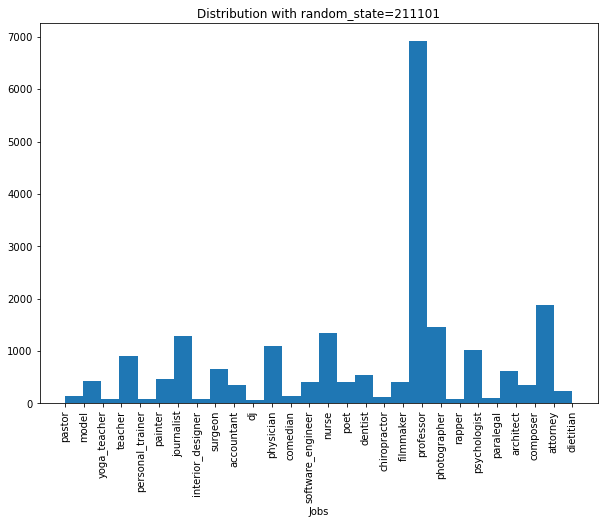

In [6]:
plt.figure(figsize=(10, 7))
plt.hist(data['Category'], 28)
plt.title("Distribution with random_state=211101")
plt.xlabel("Jobs")
plt.xticks(ticks = range(28), labels = category['0'], rotation = 'vertical')
plt.show()

On s'aperçoit que toutes les classes sont bien représentées.

## Préprocessing des extraits de CV

On crée une méthode permettant le préprocessing des extraits de CV. 

In [7]:
'''
Preprocess a CV extract
:parameter
    :param text: string - CV extract
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
    :param number: bool - whether number removal is to be applied
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned CV extract
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=None):
    ## clean --> convert to lowercase and remove punctuations and characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    ## remove number in the text
    if number == True:
        text = re.sub('[0-9]+', '', text)
            
    ## convert from string to list
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.SnowballStemmer("english")
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

On récupère la liste de stopwords du module `nltk`.

In [8]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taver\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On applique la fonction de préprocessing à la liste des extraits de CV. Le retour de la fonction est stocké dans une nouvelle colonne : `description_clean`.

In [9]:
nltk.download('wordnet')
data_clean = data
data_clean["description_clean"] = data_clean["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=lst_stopwords))
data_clean.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taver\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Id                                        description gender  \
186425  186425   Mr. Bossenbroek primarily represents healthca...      M   
106264  106264   He is also affiliated with the Center for Eco...      M   
51484    51484   He has testified in a number of forums. Eric ...      M   
80136    80136   Prior to joining CEIBS, she was an Associate ...      F   
139681  139681   Med (Bioethics and Health Law) degrees. He at...      M   

        Category                                  description_clean  
186425        26  mr bossenbroek primarily represents healthcare...  
106264        19  also affiliated center economic policy researc...  
51484          9  testified number forum eric began career audit...  
80136         19  prior joining ceibs associate professor manage...  
139681        26  med bioethics health law degree attends legal ...

## Première Vectorisation avec Count et TF-IDF
### Vectorizer Count
On applique le vectorizer `Count`. Il est basé sur la fréquence des mots.  

Cependant, cette méthode est peu utilisée, car un mot peut être très fréquent mais peu prédictif.

In [10]:
## Count (classic BoW)
vectorizerCount = feature_extraction.text.CountVectorizer(ngram_range=(1,1))

Application du modèle de vectorisation `Count` et affichage du nombre de mots dans le vocabulaire.

In [11]:
vectorizerCount.fit(data_clean["description_clean"])
data_count = vectorizerCount.transform(data_clean["description_clean"])
dic_vocabulary_Count = vectorizerCount.vocabulary_
len(dic_vocabulary_Count)

57990

 ### Vectorizer TF-IDF

La méthode `TF-IDF` semble plus adéquate pour notre application et permet de pallier au problème précédent.

In [12]:
## Tf-Idf (advanced variant of BoW)
vectorizerTfidf = feature_extraction.text.TfidfVectorizer(ngram_range=(1,1))

Application du modèle de vectorisation `TF-IDF` et affichage du nombre de mots dans le vocabulaire.

In [13]:
vectorizerTfidf.fit(data_clean["description_clean"])
data_Tfidf = vectorizerTfidf.transform(data_clean["description_clean"])
dic_vocabulary_Tfidf = vectorizerTfidf.vocabulary_
len(dic_vocabulary_Tfidf)

57990

## Sélection des features avec la méthode du Chi2

### Vectorizer Count

On applique le test du `Chi2` pour le vectorizer `Count`.

In [14]:
y = data_clean["Category"]
X_features_count = vectorizerCount.get_feature_names()

p_value_limit = 0.95
dtf_features_count = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(data_count, y==cat)
    dtf_features_count = dtf_features_count.append(pd.DataFrame({"feature":X_features_count, "score":1-p, "y":cat}))
    dtf_features_count = dtf_features_count.sort_values(["y","score"], ascending=[True,False])
    dtf_features_count = dtf_features_count[dtf_features_count["score"]>p_value_limit]
X_features_count = dtf_features_count["feature"].unique().tolist()


La taille actuelle des features après sélection est :

In [15]:
len(X_features_count)

46890

On affiche le nombre de features sélectionnées ainsi que le top 10 pour chaque catégorie :

In [16]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:", len(dtf_features_count[dtf_features_count["y"]==cat]))
   print("  . top features:", ",".join( dtf_features_count[dtf_features_count["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 1211
  . top features: abe,abingdon,adolph,afflicted,alaina,alban,alberni,ambrose,amedal,amended
 
# 1:
  . selected features: 2745
  . top features: acting,actress,ad,adaa,advertisement,aeryne,ambrosio,amyee,amyees,anoop
 
# 2:
  . selected features: 1049
  . top features: aastha,absolutely,admin,aegina,ahnu,ailey,alaya,alecia,align,aligning
 
# 3:
  . selected features: 3998
  . top features: anat,ap,baniel,barefoot,brandie,cabin,child,class,classroom,coach
 
# 4:
  . selected features: 705
  . top features: ace,achieve,aerobics,apprecia,arpe,arren,assisting,athlete,athletic,ballerina
 
# 5:
  . selected features: 3301
  . top features: abstract,abstracted,abstraction,acrylic,aristides,art,artbank,artist,artwork,atelier
 
# 6:
  . selected features: 5386
  . top features: affair,afghanistan,al,anchor,appeared,appointment,arrested,bbc,bbcs,bestseller
 
# 7:
  . selected features: 864
  . top features: accessory,accordance,accuse,affordably,aginginplace,ahma

### Vectorizer TF-IDF

On applique le test du `Chi2` pour le vectorizer `TF-IDF`.

In [17]:
y = data_clean["Category"]
X_features_Tfidf = vectorizerTfidf.get_feature_names()

p_value_limit = 0.95 
dtf_features_Tfidf = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(data_Tfidf, y==cat)
    dtf_features_Tfidf = dtf_features_Tfidf.append(pd.DataFrame({"feature":X_features_Tfidf, "score":1-p, "y":cat}))
    dtf_features_Tfidf = dtf_features_Tfidf.sort_values(["y","score"], ascending=[True,False])
    dtf_features_Tfidf = dtf_features_Tfidf[dtf_features_Tfidf["score"]>p_value_limit]
X_features_Tfidf = dtf_features_Tfidf["feature"].unique().tolist()

La taille actuelle des features après sélection est :

In [18]:
len(X_features_Tfidf)

30497

On affiche le nombre de features sélectionnées ainsi que le top 10 pour chaque catégorie :

In [19]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:", len(dtf_features_Tfidf[dtf_features_Tfidf["y"]==cat]))
   print("  . top features:", ",".join(dtf_features_Tfidf[dtf_features_Tfidf["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 684
  . top features: bible,chaplain,christ,church,congregation,daughterinlaw,discipleship,divinity,ecumenical,faith
 
# 1:
  . selected features: 1486
  . top features: actress,born,cm,currently,curvy,fashion,freeones,gallery,link,listed
 
# 2:
  . selected features: 557
  . top features: aegina,alignment,asana,ashtanga,breath,capitola,class,cramped,creatorproducer,elizayogapluscoza
 
# 3:
  . selected features: 1756
  . top features: classroom,grade,student,teacher,teaching,elementary,kindergarten,class,lesson,education
 
# 4:
  . selected features: 408
  . top features: apprecia,arpe,arren,ballerina,barbell,blueprinttm,bodyweight,cameraready,cardio,chakabar
 
# 5:
  . selected features: 1605
  . top features: acrylic,art,artist,artwork,bfa,brush,canvas,color,drawing,exhibited
 
# 6:
  . selected features: 1891
  . top features: correspondent,covered,covering,daily,editor,guardian,herald,investigative,journalism,journalist
 
# 7:
  . selected features: 497

## Seconde Vectorisation Count et TF-IDF

### Vectorizer Count

In [20]:
## Count (classic BoW)
vectorizerCount = feature_extraction.text.CountVectorizer(vocabulary=X_features_count)

Application du modèle de vectorisation `Count`.

In [21]:
vectorizerCount.fit(data_clean["description_clean"])
data_count = vectorizerCount.transform(data_clean["description_clean"])
dic_vocabulary_Count = vectorizerCount.vocabulary_
len(dic_vocabulary_Count)

46890

### Vectorizer TF-IDF

In [22]:
## Tf-Idf (advanced variant of BoW)
vectorizerTfidf = feature_extraction.text.TfidfVectorizer(vocabulary=X_features_Tfidf)

Application du modèle de vectorisation `TF-IDF`.

In [23]:
vectorizerTfidf.fit(data_clean["description_clean"])
data_Tfidf = vectorizerTfidf.transform(data_clean["description_clean"])
dic_vocabulary_Tfidf = vectorizerTfidf.vocabulary_
len(dic_vocabulary_Tfidf)

30497

## Séparation du dataset en train et test

### Vectorizer Count

In [24]:
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(data_count, data_clean["Category"], test_size=0.2, random_state=211101)

### Vectorizer TF-IDF

In [25]:
X_Tfidf_train, X_Tfidf_test, y_Tfidf_train, y_Tfidf_test = train_test_split(data_Tfidf, data_clean["Category"], test_size=0.2, random_state=211101)

## Entrainement des modèles de machine learning

Pour l'ensemble des modèles choisis, on réalise une pipeline permettant de tester et d'évaluer les modèles en fonction d'une combinaison d'hyperparamètres.  

Les deux méthodes suivantes permettent d'afficher les résultats de façon générale pour chaque modèle.

### Création d'une fonction pour étudier les résultats du modèle entrainé

In [26]:
'''
Affichage des résultats du modèle entrainé
:parameter
    :param model: Le modèle entrainé
    :param X_train: Le dataset d'entrée train
    :param y_train: Le dataset de sortie train
    :param X_test: Le dataset d'entrée test
    :param y_test: Le dataset de sortie train
'''
def display_stats_model_trained(model, X_train, y_train, X_test, y_test, display_graphics):

    ## Accuracy train and test, Precision, Recall
    #auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy:")
    print("\rTrain: ", model.score(X_train, y_train))
    print("\rTest: ", model.score(X_test, y_test))
    #print("Area under the curve (Auc): ", auc)
    print("")
    
    # Get predictions
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    if display_graphics == True:
        # Get dataset test categories
        classes = np.unique(y_test)
        y_test_array = pd.get_dummies(y_test, drop_first=False).values
        print("Detail:")
        print(metrics.classification_report(y_test, predicted))

        ## Plot confusion matrix
        cm = metrics.confusion_matrix(y_test, predicted)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
        plt.yticks(rotation=0)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                  xlabel='False Positive Rate', 
                  ylabel="True Positive Rate (Recall)", 
                  title="Receiver operating characteristic")
        ax[0].legend(loc="lower right")
        ax[0].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = metrics.precision_recall_curve(
                         y_test_array[:,i], predicted_prob[:,i])
            ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i],  metrics.auc(recall, precision)))
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
        ax[1].legend(loc="best")
        ax[1].grid(True)
        plt.show()

Définitions utilisées pour comprendre la précision et le rappel :  

**Precision** : What proportion of positive identifications was actually correct?  
**Recall**: What proportion of actual positives was identified correctly?

### Création d'une fonction pour obtenir et afficher les résultats de la pipeline

In [27]:
def train_and_display_pipeline_results(model_grid, X_train, y_train, X_test, y_test):
    print('Train Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_test, y_test))
    print('Best Accuracy Through Grid Search : ', model_grid.best_score_)
    print('Best Parameters : ',model_grid.best_params_)
    

### Entrainement du modèle avec la famille d'algortihmes Naive Bayes

La famille d'algorithmes statistiques Naive Bayes, fait partie des algorithmes les plus utilisé dans la classification de texte.  
 
Le lien suivant revoit vers la documentation : https://scikit-learn.org/stable/modules/naive_bayes.html. Il y est notamment indiqué que `MultinomialNB`, `ComplementNB` et `BernoulliNB` sont les trois algorithmes de la famille les plus adaptés pour la classification de texte.

#### Entrainement du modèle avec MultinomialNB

##### Avec le vectorizer Count

In [28]:
naive_bayes_Multinomial_count = naive_bayes.MultinomialNB()

params = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
         }

naive_bayes_Multinomial_count_Grid = GridSearchCV(naive_bayes_Multinomial_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Multinomial_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(naive_bayes_Multinomial_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    2.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.5s finished


Train Accuracy Best Estimator :  0.9175827338129496
Test Accuracy Best Estimator :  0.7133977900552486
Best Accuracy Through Grid Search :  0.7149352517985612
Best Parameters :  {'alpha': 0.1}


##### Avec le vectorizer TF-IDF

In [29]:
naive_bayes_Multinomial_Tfidf = naive_bayes.MultinomialNB()

params = {
        'alpha': [0.001, 0.1, 0.25, 1.0, 10.0]
         }

naive_bayes_Multinomial_Tfidf_Grid = GridSearchCV(naive_bayes_Multinomial_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Multinomial_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(naive_bayes_Multinomial_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.4s finished


Train Accuracy Best Estimator :  0.952748201438849
Test Accuracy Best Estimator :  0.6956721915285451
Best Accuracy Through Grid Search :  0.700546762589928
Best Parameters :  {'alpha': 0.001}


On obtient le meilleur résultat sur la base du vectorizer `Count`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.9175827338129496
Test:  0.7133977900552486

Detail:
              precision    recall  f1-score   support

           0       0.43      0.50      0.47        20
           1       0.70      0.68      0.69        90
           2       0.75      0.26      0.39        23
           3       0.40      0.53      0.45       186
           4       0.67      0.12      0.20        17
           5       0.65      0.63      0.64       118
           6       0.59      0.69      0.64       239
           7       0.50      0.04      0.08        23
           8       0.72      0.68      0.70       129
           9       0.72      0.59      0.65        75
          10       0.33      0.25      0.29        12
          11       0.57      0.62      0.60       212
          12       0.75      0.54      0.63        39
          13       0.57      0.60      0.59        65
          14       0.83      0.70      0.76       264
          15       0.58      0.73      0.65        96
         

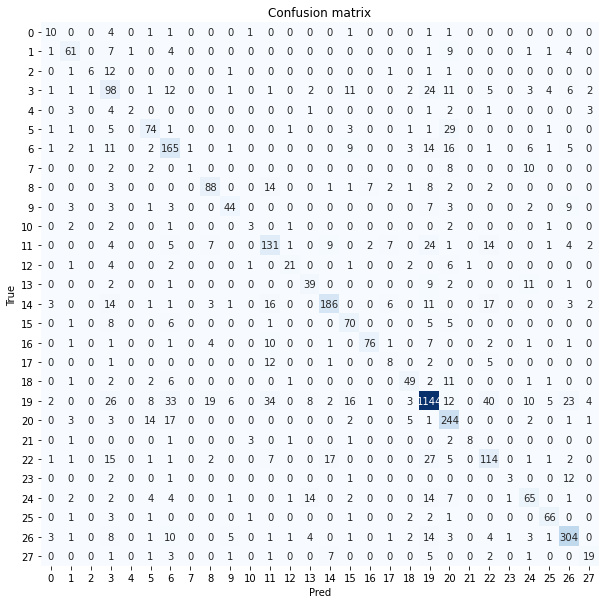

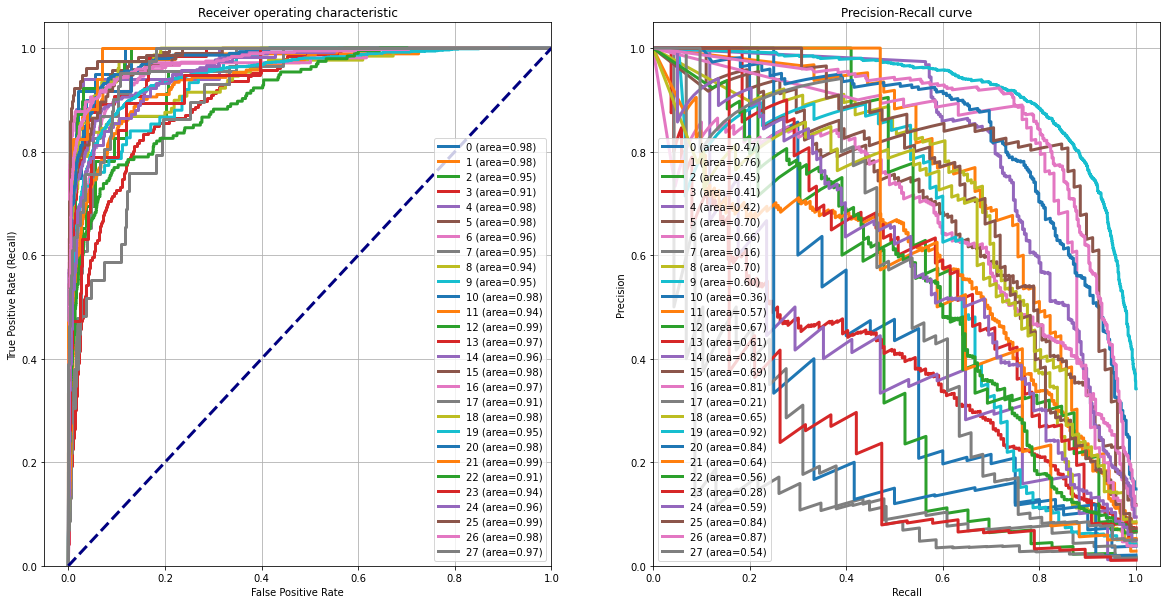

In [30]:
naive_bayes_Multinomial = naive_bayes.MultinomialNB(alpha=0.1)
naive_bayes_Multinomial.fit(X_count_train, y_count_train)

display_stats_model_trained(naive_bayes_Multinomial, X_count_train, y_count_train, X_count_test, y_count_test, True)

#### Entrainement du modèle avec ComplementNB

##### Avec le vectorizer Count

In [31]:
naive_bayes_Complement_count = naive_bayes.ComplementNB()

params = {
        'alpha': [0.001, 0.1, 0.25, 1.0, 10.0],
        'norm' : [True, False]
         }

naive_bayes_Complement_count_Grid = GridSearchCV(naive_bayes_Complement_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Complement_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(naive_bayes_Complement_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished


Train Accuracy Best Estimator :  0.8777553956834533
Test Accuracy Best Estimator :  0.7140883977900553
Best Accuracy Through Grid Search :  0.7137841726618706
Best Parameters :  {'alpha': 1.0, 'norm': False}


##### Avec le vectorizer TF-IDF

In [32]:
naive_bayes_Complement_Tfidf = naive_bayes.ComplementNB()

params = {
        'alpha': [0.01,  0.1, 0.25, 1.0, 10.0],
        'norm' : [True, False]
         }

naive_bayes_Complement_Tfidf_Grid = GridSearchCV(naive_bayes_Complement_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Complement_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(naive_bayes_Complement_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  50 | elapsed:    0.5s remaining:    0.6s


Train Accuracy Best Estimator :  0.8922589928057554
Test Accuracy Best Estimator :  0.7154696132596685
Best Accuracy Through Grid Search :  0.7177553956834533
Best Parameters :  {'alpha': 0.25, 'norm': False}


[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.8922589928057554
Test:  0.7154696132596685

Detail:
              precision    recall  f1-score   support

           0       0.44      0.60      0.51        20
           1       0.71      0.59      0.64        90
           2       0.76      0.57      0.65        23
           3       0.45      0.18      0.26       186
           4       0.62      0.47      0.53        17
           5       0.76      0.50      0.60       118
           6       0.65      0.58      0.61       239
           7       0.57      0.17      0.27        23
           8       0.71      0.59      0.64       129
           9       0.81      0.39      0.52        75
          10       0.27      0.25      0.26        12
          11       0.60      0.56      0.58       212
          12       0.74      0.64      0.68        39
          13       0.62      0.37      0.46        65
          14       0.76      0.77      0.76       264
          15       0.78      0.73      0.75        96
         

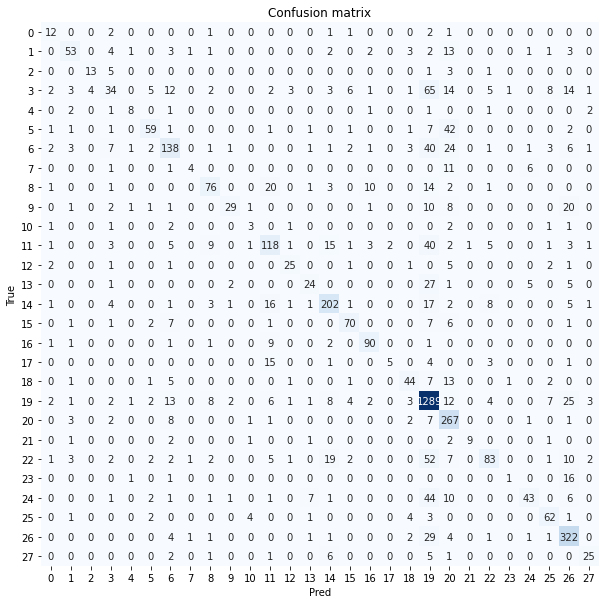

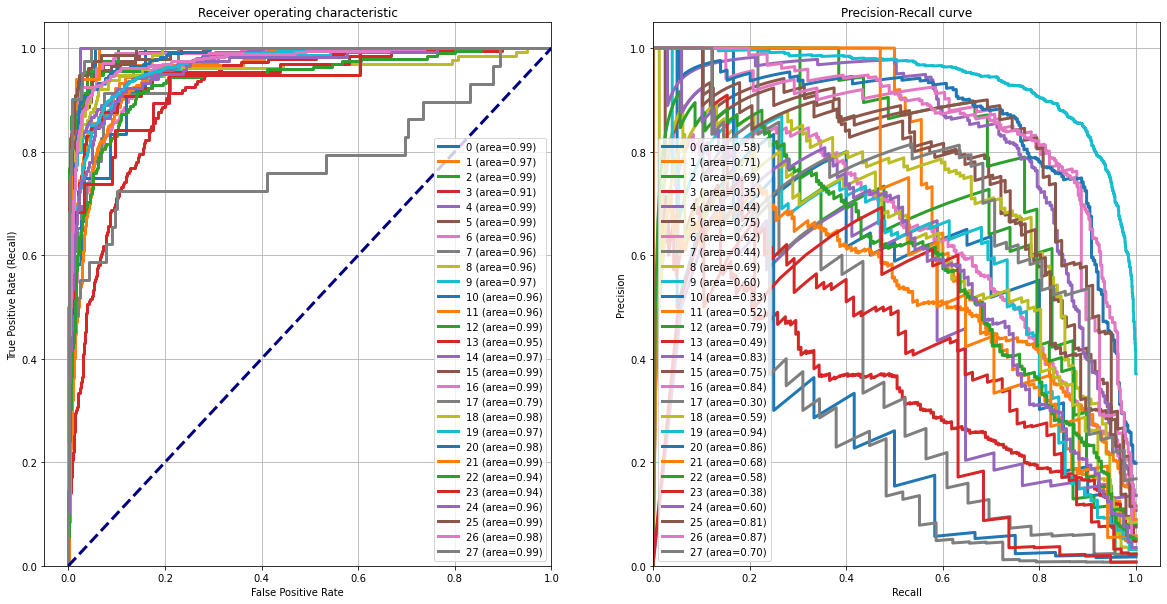

In [33]:
naive_bayes_Complement = naive_bayes.ComplementNB(alpha=0.25, norm=False)
naive_bayes_Complement.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(naive_bayes_Complement, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

#### Entrainement du modèle avec BernoulliNB

##### Avec le vectorizer Count

In [91]:
naive_bayes_Bernoulli_count = naive_bayes.BernoulliNB()

params = {
        'alpha': [0.001, 0.1, 0.25, 1.0, 10.0]
         }

naive_bayes_Bernoulli_count_Grid = GridSearchCV(naive_bayes_Bernoulli_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Bernoulli_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(naive_bayes_Bernoulli_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished


Train Accuracy Best Estimator :  0.8869640287769784
Test Accuracy Best Estimator :  0.6924493554327809
Best Accuracy Through Grid Search :  0.6895539568345324
Best Parameters :  {'alpha': 0.1}


##### Avec le vectorizer TF-IDF

In [92]:
naive_bayes_Bernoulli_Tfidf = naive_bayes.BernoulliNB()

params = {
        'alpha': [0.01, 0.1, 0.25, 1.0, 10.0]
         }

naive_bayes_Bernoulli_Tfidf_Grid = GridSearchCV(naive_bayes_Bernoulli_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
naive_bayes_Bernoulli_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(naive_bayes_Bernoulli_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished


Train Accuracy Best Estimator :  0.9030791366906474
Test Accuracy Best Estimator :  0.7173112338858195
Best Accuracy Through Grid Search :  0.7210935251798561
Best Parameters :  {'alpha': 0.01}


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.9030791366906474
Test:  0.7173112338858195
Detail:
              precision    recall  f1-score   support

           0       0.27      0.60      0.37        20
           1       0.70      0.72      0.71        90
           2       0.73      0.48      0.58        23
           3       0.38      0.52      0.44       186
           4       0.69      0.53      0.60        17
           5       0.71      0.64      0.67       118
           6       0.59      0.70      0.64       239
           7       0.47      0.30      0.37        23
           8       0.74      0.67      0.70       129
           9       0.65      0.59      0.62        75
          10       0.36      0.33      0.35        12
          11       0.54      0.58      0.56       212
          12       0.93      0.67      0.78        39
          13       0.64      0.66      0.65        65
          14       0.87      0.66      0.75       264
          15       0.68      0.70      0.69        96
          

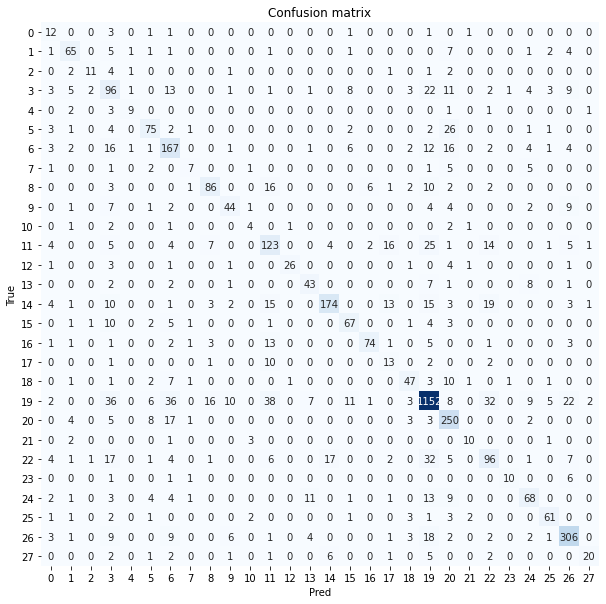

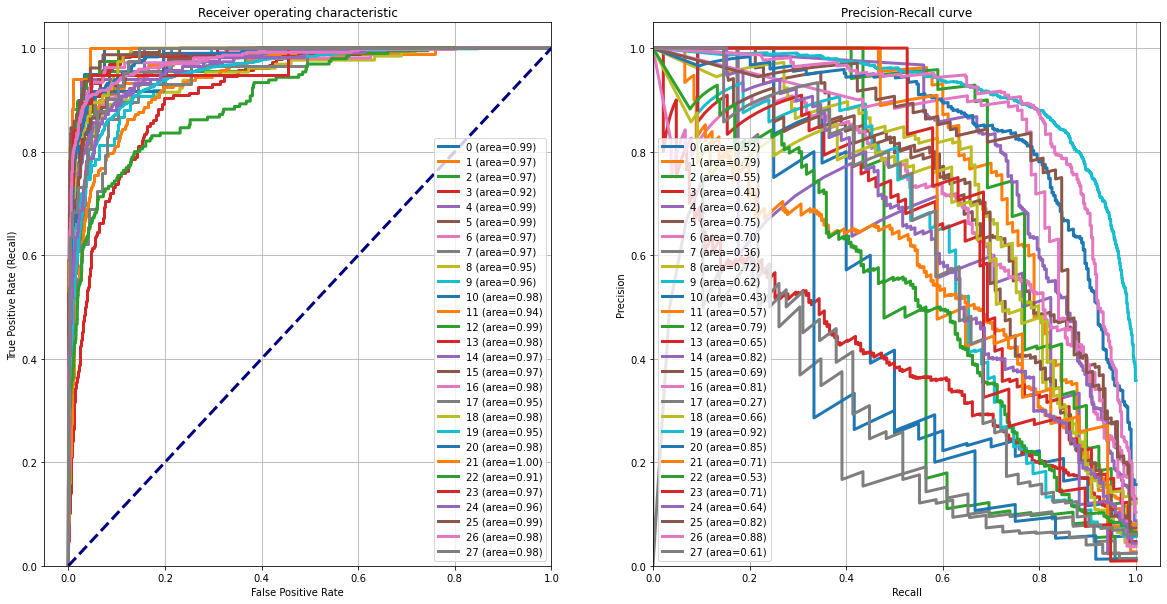

In [93]:
naive_bayes_Bernoulli = naive_bayes.BernoulliNB(alpha=0.01)
naive_bayes_Bernoulli.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(naive_bayes_Bernoulli, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

### Entrainement du modèle avec le classifier Random Forest

##### Avec le vectorizer Count

In [ ]:
randomForest_count= RandomForestClassifier()

params = {
        'n_estimators': [100, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [100, 500]
         }

randomForest_count_Grid = GridSearchCV(randomForest_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
randomForest_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(randomForest_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min


##### Avec le vectorizer TF-IDF

In [102]:
randomForest_Tdidf= RandomForestClassifier()

params = {
        'n_estimators': [100, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [100, 500]
         }

randomForest_Tfidf_Grid = GridSearchCV(randomForest_Tdidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
randomForest_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(randomForest_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  2.5min remaining:   50.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished


Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.7028084714548803
Best Accuracy Through Grid Search :  0.6991654676258994
Best Parameters :  {'max_depth': 500}


On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

Accuracy:
Train:  0.9828489208633093
Test:  0.6788674033149171
Detail:


c:\users\taver\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.10      0.18        20
           1       0.98      0.48      0.64        90
           2       0.91      0.43      0.59        23
           3       0.62      0.17      0.26       186
           4       1.00      0.06      0.11        17
           5       0.93      0.53      0.68       118
           6       0.67      0.50      0.57       239
           7       0.00      0.00      0.00        23
           8       0.86      0.53      0.66       129
           9       0.96      0.35      0.51        75
          10       1.00      0.17      0.29        12
          11       0.70      0.50      0.58       212
          12       0.95      0.51      0.67        39
          13       0.83      0.15      0.26        65
          14       0.95      0.73      0.82       264
          15       0.93      0.55      0.69        96
          16       0.86      0.87      0.86       106
          17       1.00    

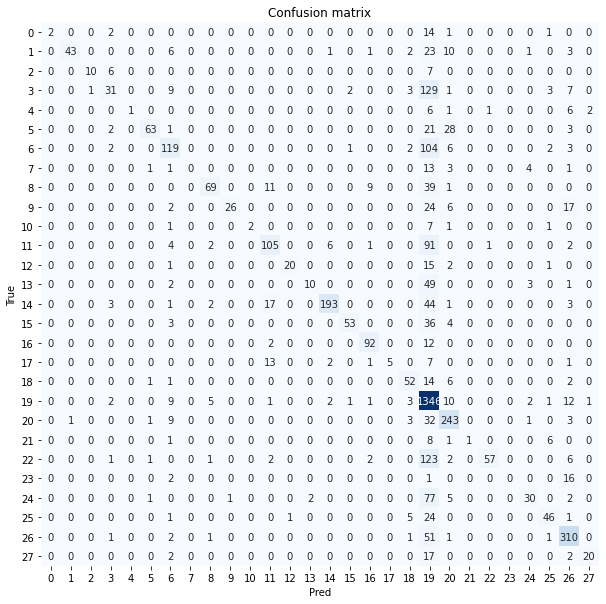

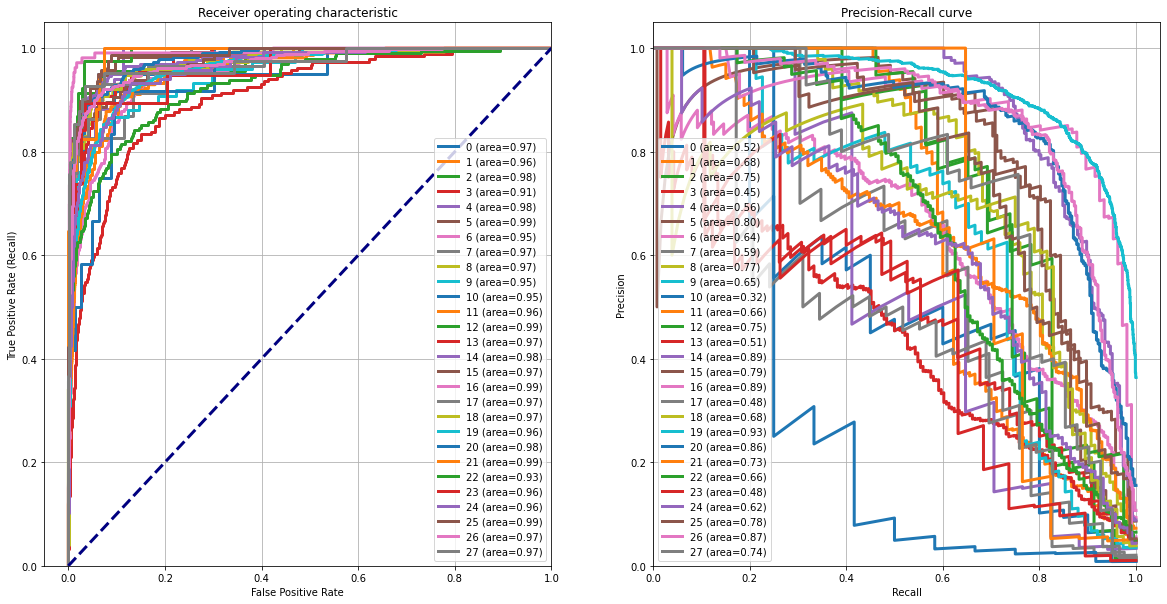

In [103]:
radom_forest_Tfidf = RandomForestClassifier(max_depth=100, random_state=0)
radom_forest_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(radom_forest_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

### Entrainement du modèle avec le classifier KNN

##### Avec le vectorizer Count

In [ ]:
kNeighbors_count= KNeighborsClassifier()

params = {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance']
         }

kNeighbors_count_Grid = GridSearchCV(kNeighbors_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
kNeighbors_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(kNeighbors_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

##### Avec le vectorizer TF-IDF

kNeighbors_Tfidf= KNeighborsClassifier()

params = {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance']
         }

kNeighbors_Tfidf_Grid = GridSearchCV(kNeighbors_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
kNeighbors_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(radom_forest_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

On obtient le meilleur résultat sur la base du vectorizer `TF-IDF`.    

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

In [ ]:
KNN_Tfidf = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(KNN_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

### Entrainement du modèle avec le classifier Neural Network

Pour des raisons de ressources matérielles à notre disposition, nous n'avons pas pu mettre en place une pipeline pour ce type de classifier. En effet, le nombre d'hyperparamètres étant important, la pipeline prenait un temps trop conséquent. L'étude se fera donc en pas à pas sur ce modèle.

##### Avec le vectorizer Count

On utilise ici le solver `lbgs` qui a pour propriété de converger plus vite. Il est également plus adapté pour des petits datasets de données contrairement aux deux autres `adam` et `sgd`. On commence avec **2 layers de 20 neurones**, un **alpha** correspondant à la pénalisation de **1** et un **maximum d'itération égal à 5000**.

Accuracy:
Test:  0.7017014270032931
Train:  1.0
Detail:
              precision    recall  f1-score   support

           0       0.48      0.30      0.37        44
           1       0.67      0.66      0.67        94
           2       0.67      0.50      0.57        12
           3       0.48      0.51      0.49       179
           4       0.47      0.50      0.48        14
           5       0.75      0.66      0.70        99
           6       0.61      0.63      0.62       249
           7       0.41      0.47      0.44        15
           8       0.57      0.64      0.60       105
           9       0.59      0.59      0.59        61
          10       0.46      0.43      0.44        14
          11       0.67      0.71      0.69       241
          12       0.65      0.62      0.63        21
          13       0.56      0.58      0.57        83
          14       0.85      0.81      0.83       264
          15       0.73      0.70      0.71        73
          16       0.90  

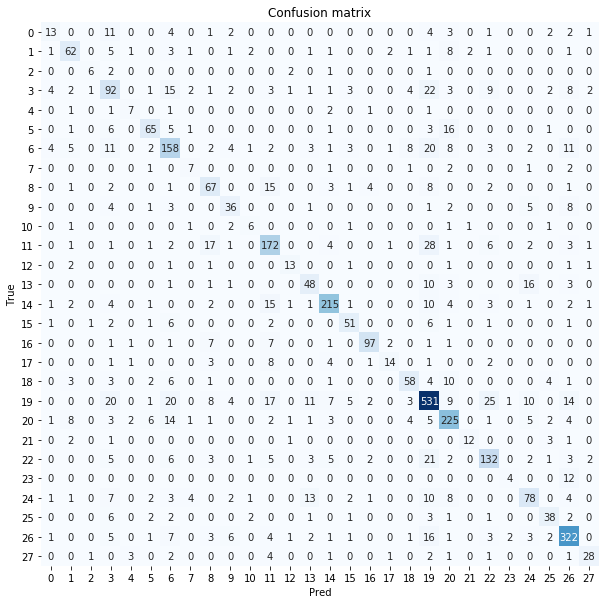

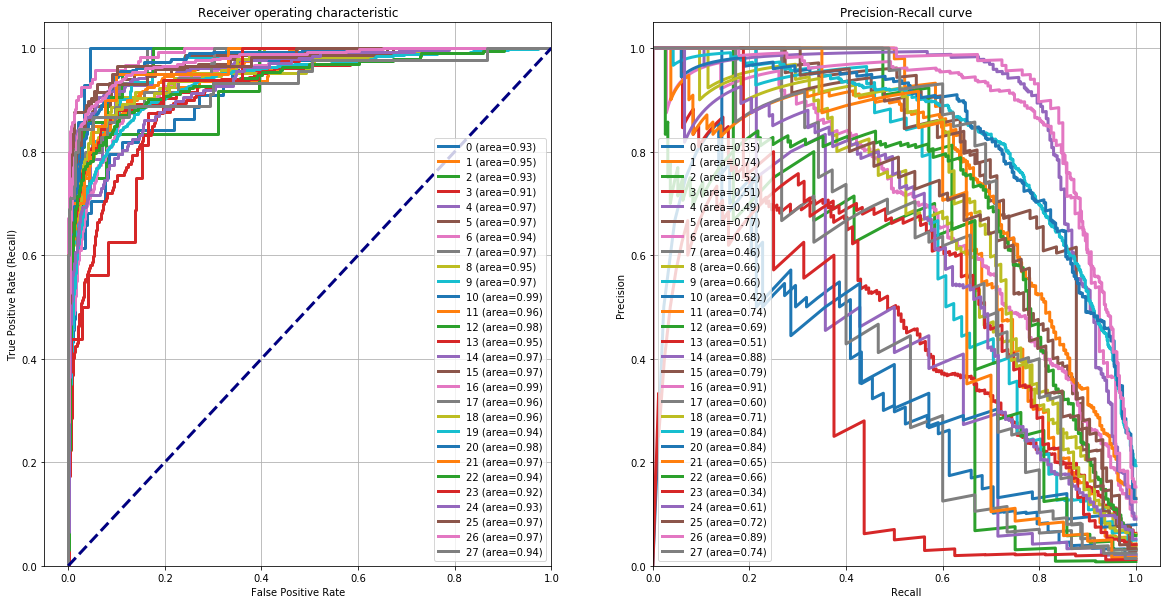

In [46]:
nn_count = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(20,20), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_count.fit(X_count_train, y_count_train)

display_stats_model_trained(nn_count, X_count_train, y_count_train, X_count_test, y_count_test, True)

##### Avec le vectorizer TF-IDF

On reprend les mêmes hyperparamètres pour l'entrainement du modèle basé sur le vectorizer `TF-IDF`.

Accuracy:
Test:  0.6975850713501647
Train:  1.0
Detail:
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        44
           1       0.70      0.68      0.69        94
           2       0.67      0.50      0.57        12
           3       0.45      0.47      0.46       179
           4       0.25      0.29      0.27        14
           5       0.65      0.74      0.69        99
           6       0.65      0.63      0.64       249
           7       0.38      0.33      0.36        15
           8       0.72      0.62      0.67       105
           9       0.76      0.56      0.64        61
          10       0.64      0.50      0.56        14
          11       0.66      0.68      0.67       241
          12       0.62      0.62      0.62        21
          13       0.66      0.54      0.60        83
          14       0.82      0.78      0.80       264
          15       0.69      0.60      0.64        73
          16       0.92  

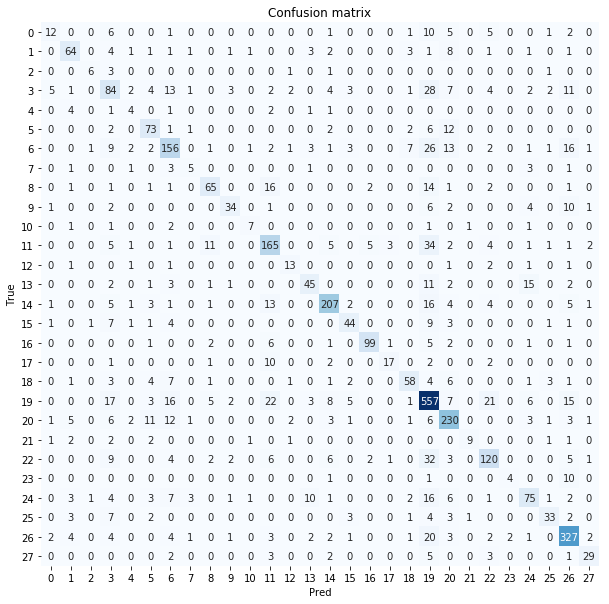

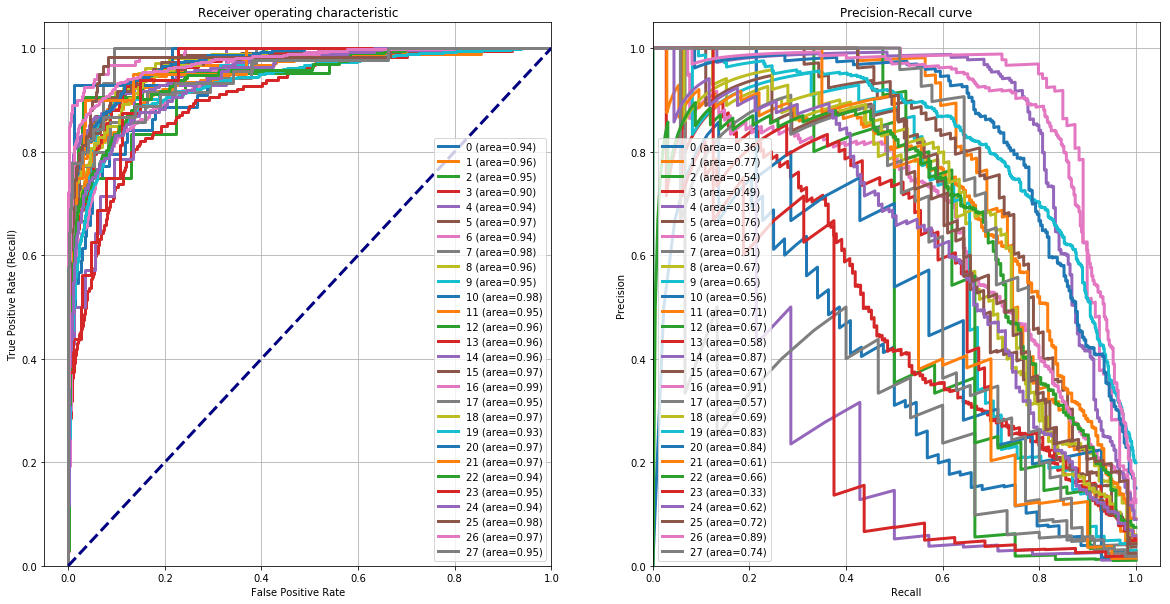

In [47]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(20,20), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

Les deux scores obtenus pour les vectorizers `TF-IDF` et `Count` sont sensiblement les mêmes. Avec les autres algorithmes, on a pu observer que les résultats associés au vectorizer `TF-IDF` étaient meilleurs que ceux de `Count`. Pour la suite, on prendra donc le dataset issue du vectorizer `TF-IDF`.  

On note un **overfitting** important du modèle qui est déjà corrigé par le paramètre `alpha`. En effet, nous avons testé pour des valeurs de `alpha` (pénalisation) plus basses et les résultats était très mauvais. 

##### Avec le vectorizer TF-IDF et un changement des layers

A présent, on teste le modèle avec une layer de 50 neurones. Le résultat de test obtenu est meilleur que précédemment.

In [35]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

Accuracy:
Train:  0.9999424460431655
Test:  0.7523020257826888



##### Avec le vectorizer TF-IDF et un changement du nombre de neurones pour la layer

On augmente le nombre de neurones pour la seule  layer du modèle. Aucune variation du score de test n'est constatée (légère baisse), on abandonne donc cette perspective (testé également pour 150 et 200).

Accuracy:
Test:  0.7340834248079035
Train:  1.0
Detail:
              precision    recall  f1-score   support

           0       0.80      0.45      0.58        44
           1       0.76      0.76      0.76        94
           2       0.75      0.50      0.60        12
           3       0.51      0.49      0.50       179
           4       1.00      0.50      0.67        14
           5       0.79      0.74      0.76        99
           6       0.65      0.72      0.68       249
           7       0.58      0.47      0.52        15
           8       0.75      0.68      0.71       105
           9       0.78      0.59      0.67        61
          10       1.00      0.57      0.73        14
          11       0.70      0.73      0.71       241
          12       0.76      0.62      0.68        21
          13       0.66      0.57      0.61        83
          14       0.83      0.78      0.80       264
          15       0.73      0.63      0.68        73
          16       0.95  

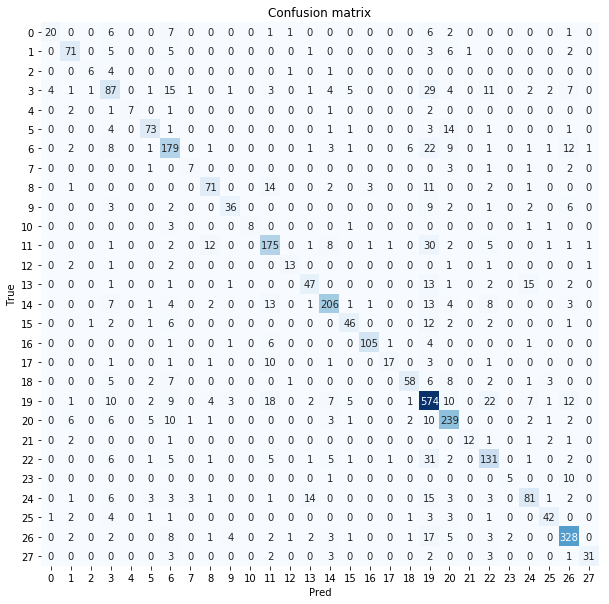

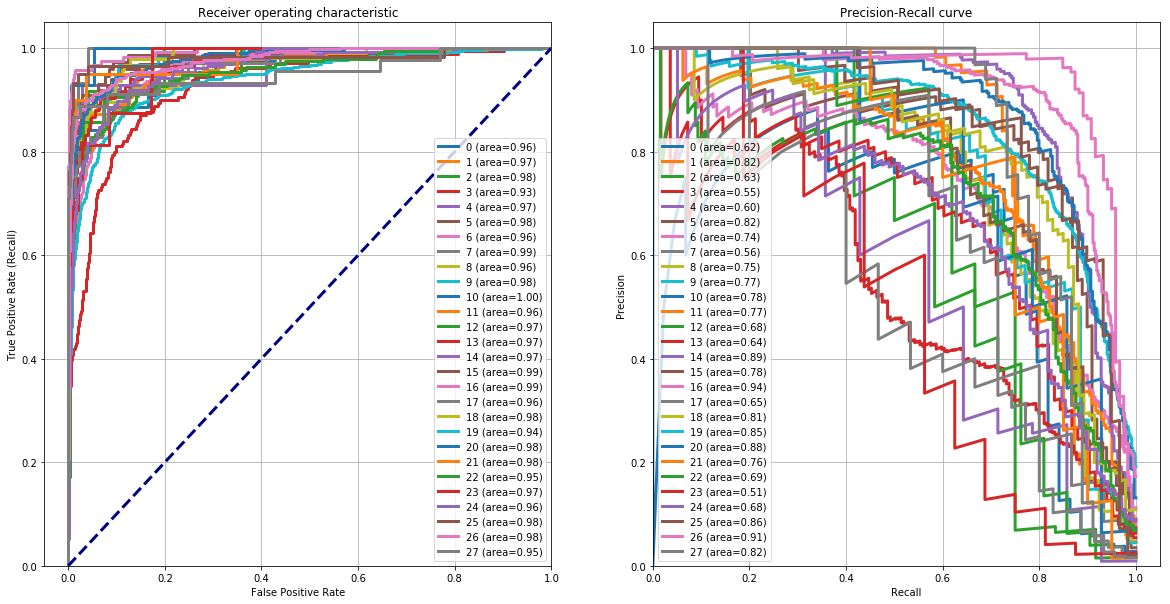

In [58]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(500), alpha=1, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

graphics_representation_model(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Avec le vectorizer TF-IDF et un changement du nombre de neurones pour la layer et du alpha

On repasse le nombre de neurones pour la layer à 50 car le résultat était meilleur pour cette valeur. On augmente également la pénalisation qui permet une hausse de la précision des valeurs de test.

Accuracy:
Test:  0.7509208103130756
Train:  0.9995971223021582
Detail:
              precision    recall  f1-score   support

           0       0.55      0.23      0.32        26
           1       0.78      0.66      0.71        85
           2       0.86      0.55      0.67        11
           3       0.46      0.48      0.47       180
           4       0.82      0.53      0.64        17
           5       0.75      0.69      0.72        87
           6       0.63      0.68      0.66       250
           7       0.67      0.29      0.40        14
           8       0.73      0.60      0.66       122
           9       0.78      0.57      0.66        61
          10       0.82      0.45      0.58        20
          11       0.69      0.76      0.72       225
          12       0.76      0.66      0.70        29
          13       0.59      0.57      0.58        83
          14       0.80      0.77      0.78       235
          15       0.77      0.63      0.69        81
          

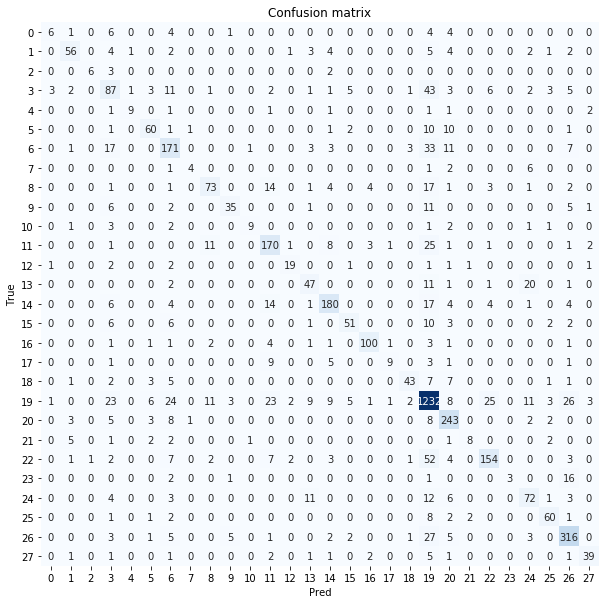

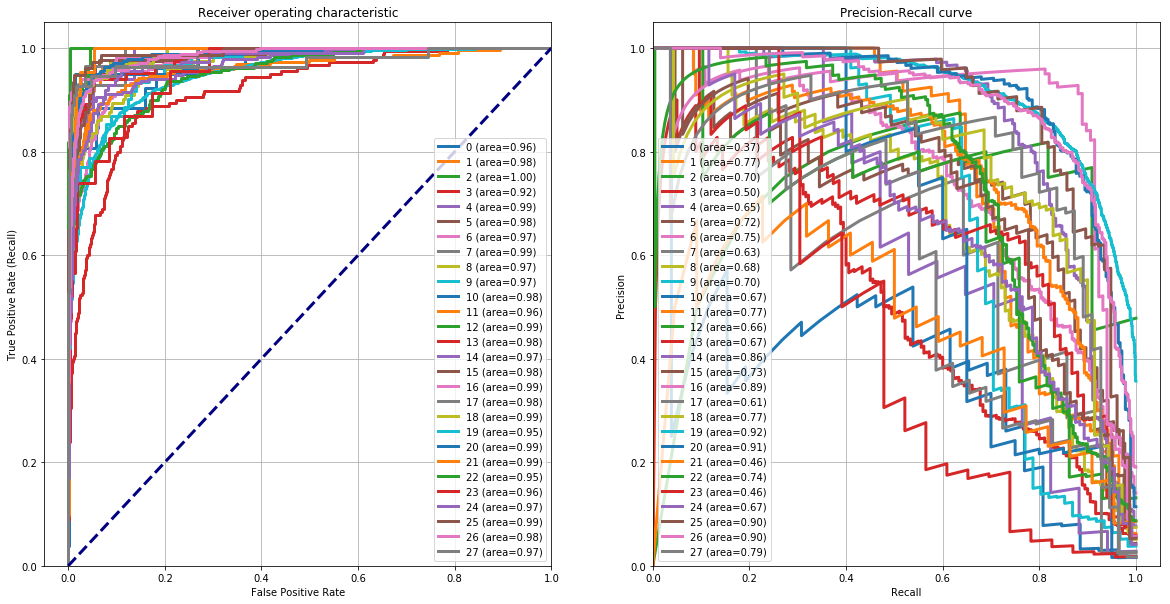

In [27]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="relu", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

##### Avec le vectorizer TF-IDF et un changement de la fonction d'activation

Après changement de la fonction d'activation de `relu` à `tanh`, le résultat obtenu devient moins précis.

Accuracy:
Test:  0.7430939226519337
Train:  0.9993669064748202
Detail:
              precision    recall  f1-score   support

           0       0.50      0.23      0.32        26
           1       0.79      0.68      0.73        85
           2       0.88      0.64      0.74        11
           3       0.45      0.47      0.46       180
           4       0.69      0.53      0.60        17
           5       0.76      0.71      0.73        87
           6       0.63      0.67      0.65       250
           7       0.67      0.29      0.40        14
           8       0.69      0.59      0.64       122
           9       0.85      0.56      0.67        61
          10       0.90      0.45      0.60        20
          11       0.67      0.74      0.71       225
          12       0.77      0.69      0.73        29
          13       0.64      0.57      0.60        83
          14       0.79      0.74      0.77       235
          15       0.73      0.58      0.65        81
          

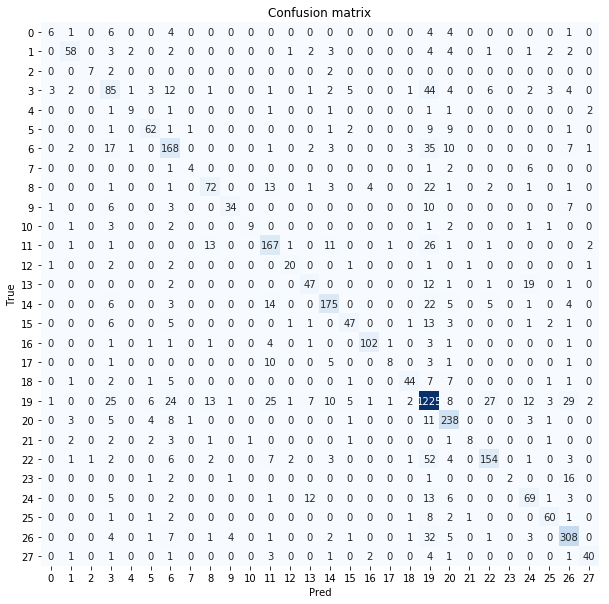

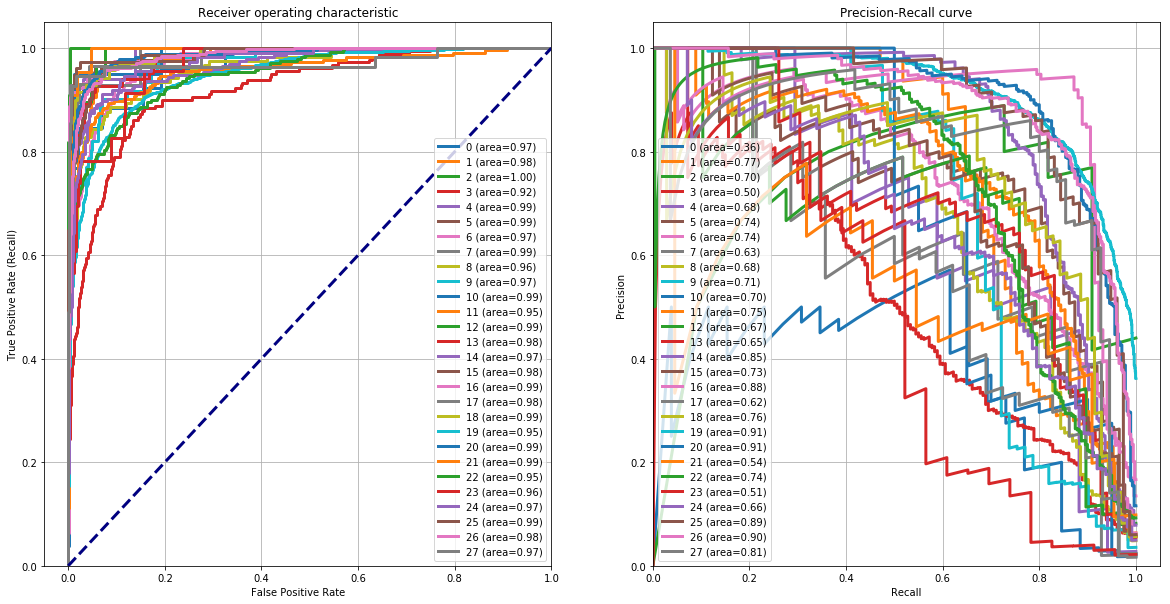

In [28]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="tanh", max_iter=5000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

graphics_representation_model(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Avec le vectorizer TF-IDF et de la fonction d'activation

Après avoir essayer le fonction d'activation `tanh`, on tente maintement le fonction `logistic`. Il n'y a pas d'améliorations.

Accuracy:
Test:  0.7428637200736649
Train:  0.8618705035971223
Detail:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.79      0.62      0.70        85
           2       0.00      0.00      0.00        11
           3       0.46      0.53      0.49       180
           4       0.00      0.00      0.00        17
           5       0.74      0.64      0.69        87
           6       0.57      0.73      0.64       250
           7       0.00      0.00      0.00        14
           8       0.78      0.61      0.68       122
           9       1.00      0.48      0.64        61
          10       0.00      0.00      0.00        20
          11       0.67      0.76      0.72       225
          12       0.81      0.45      0.58        29
          13       0.81      0.51      0.62        83
          14       0.79      0.75      0.77       235
          15       0.83      0.56      0.67        81
          

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


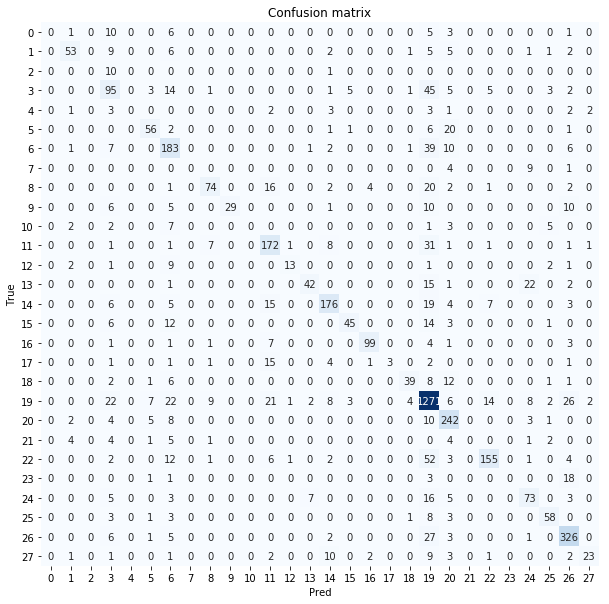

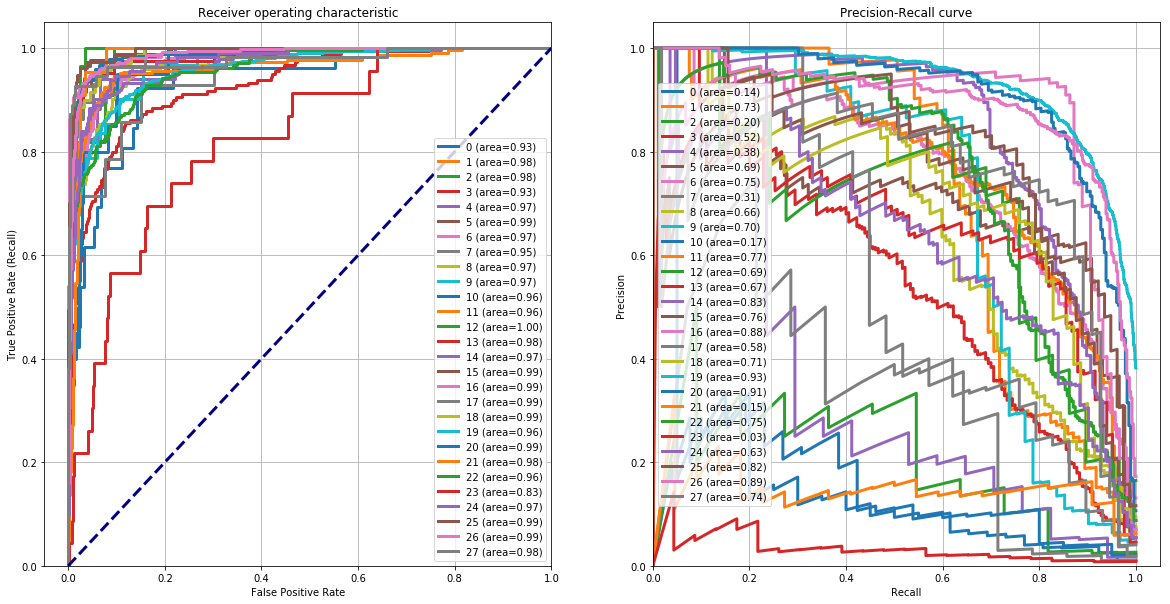

In [31]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="logistic", max_iter=1000)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Avec le vectorizer TF-IDF et changement de la fonction d'activation

De même avec la fonction `identity`.

Accuracy:
Test:  0.7419429097605893
Train:  0.9998273381294964
Detail:
              precision    recall  f1-score   support

           0       0.50      0.23      0.32        26
           1       0.79      0.68      0.73        85
           2       0.86      0.55      0.67        11
           3       0.45      0.47      0.46       180
           4       0.69      0.53      0.60        17
           5       0.76      0.71      0.73        87
           6       0.62      0.66      0.64       250
           7       0.67      0.29      0.40        14
           8       0.69      0.60      0.64       122
           9       0.82      0.54      0.65        61
          10       0.90      0.45      0.60        20
          11       0.67      0.73      0.70       225
          12       0.77      0.69      0.73        29
          13       0.62      0.57      0.59        83
          14       0.79      0.74      0.77       235
          15       0.74      0.56      0.63        81
          

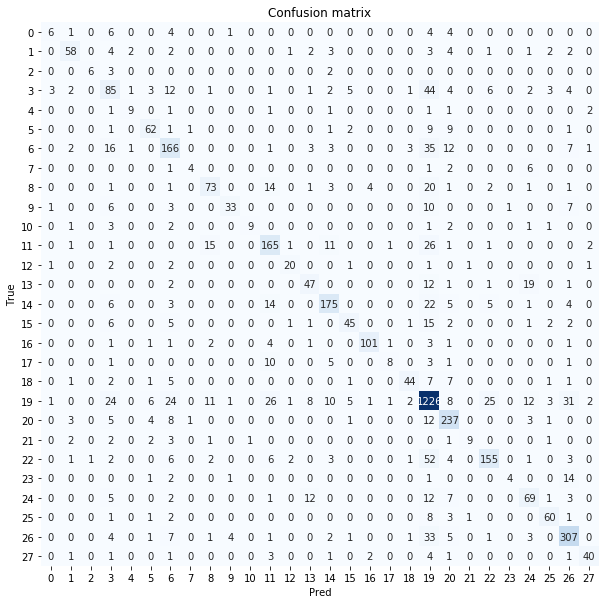

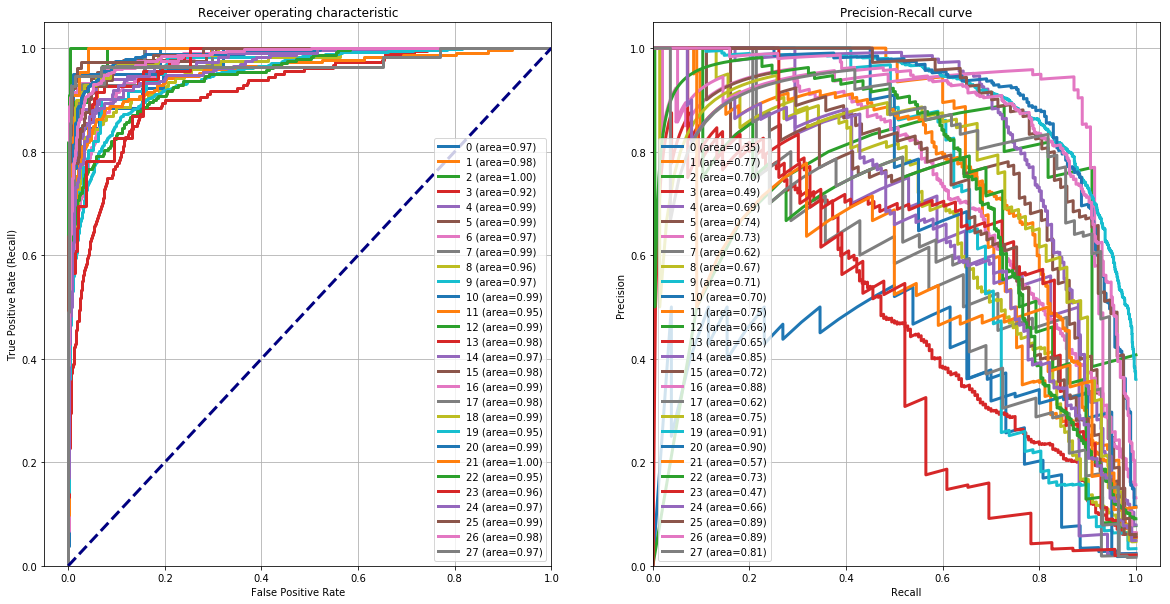

In [32]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="identity", max_iter=1000)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Avec le vectorizer TF-IDF et changement du learning rate

On tente une augmentation de la valeur du `learning_rate`, cependant le score devient moins précis.

Accuracy:
Test:  0.7490791896869244
Train:  0.995568345323741
Detail:
              precision    recall  f1-score   support

           0       0.42      0.19      0.26        26
           1       0.79      0.66      0.72        85
           2       0.86      0.55      0.67        11
           3       0.47      0.48      0.47       180
           4       0.73      0.47      0.57        17
           5       0.74      0.70      0.72        87
           6       0.62      0.68      0.65       250
           7       0.57      0.29      0.38        14
           8       0.69      0.60      0.64       122
           9       0.85      0.57      0.69        61
          10       0.90      0.45      0.60        20
          11       0.68      0.75      0.71       225
          12       0.83      0.69      0.75        29
          13       0.64      0.55      0.59        83
          14       0.79      0.75      0.77       235
          15       0.77      0.62      0.68        81
          1

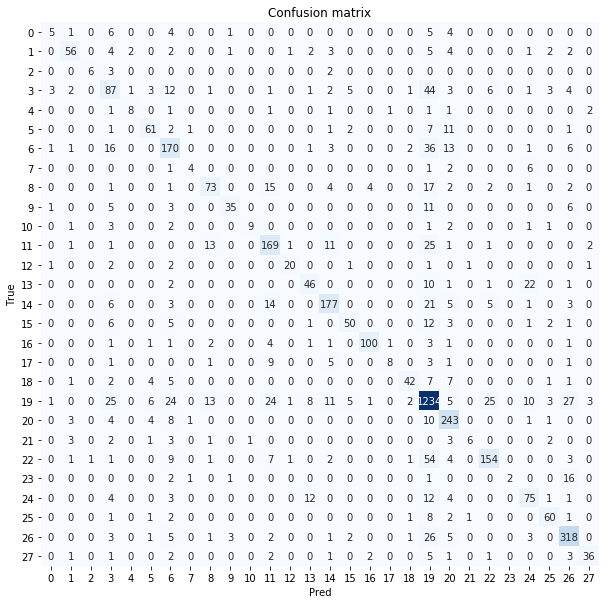

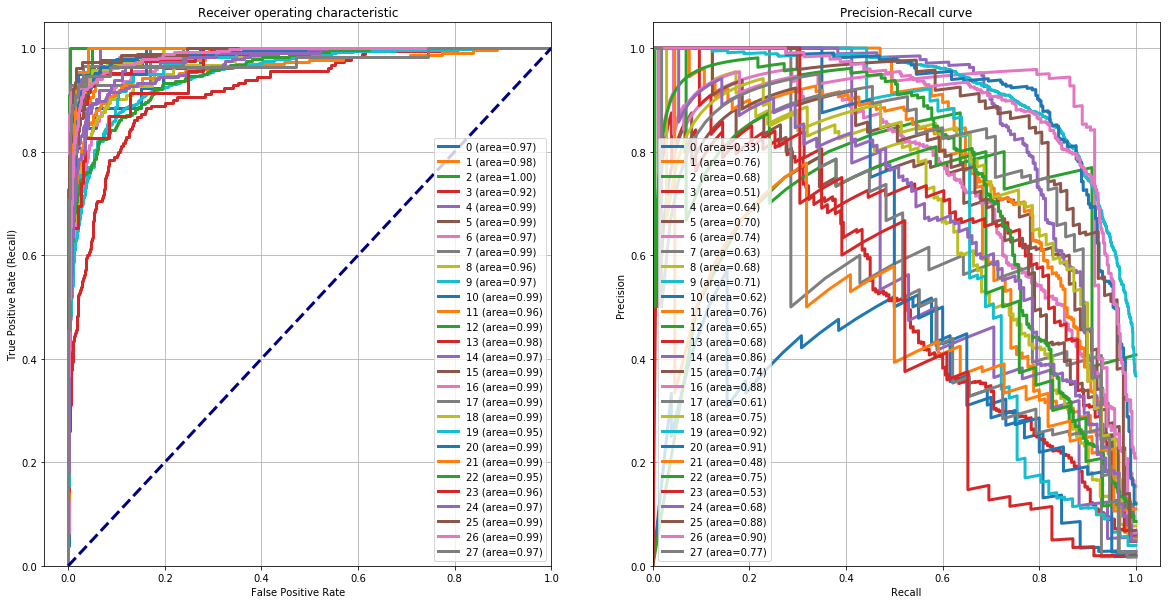

In [30]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=3, activation="relu", max_iter=1000, learning_rate= "adaptive")
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Avec le vectorizer TF-IDF et changement du solver

On réalise un changement du solver pour vérifier nos propos en début de partie. Le changement est réalisé seulement pour le solver `adam`, car il est décrit comme une version optimisée du solver `sgd` dans la documentation.

Accuracy:
Test:  0.4661602209944751
Train:  0.47522302158273383
Detail:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        85
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00       180
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        87
           6       0.00      0.00      0.00       250
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00       122
           9       0.00      0.00      0.00        61
          10       0.00      0.00      0.00        20
          11       0.55      0.18      0.27       225
          12       0.00      0.00      0.00        29
          13       0.00      0.00      0.00        83
          14       0.59      0.62      0.60       235
          15       0.00      0.00      0.00        81
         

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


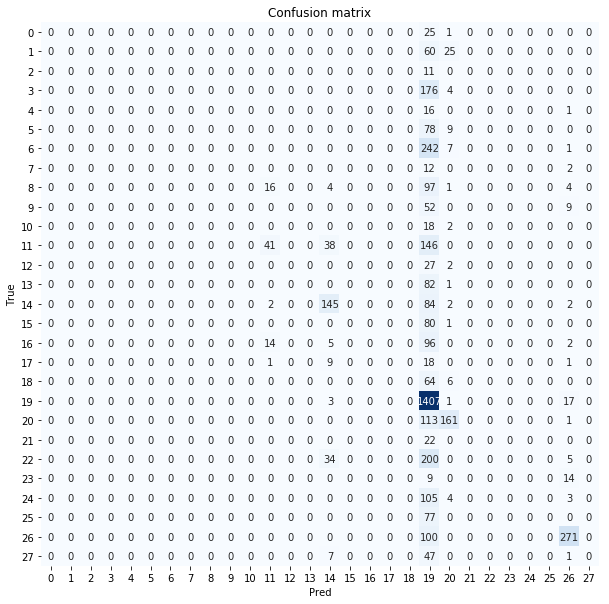

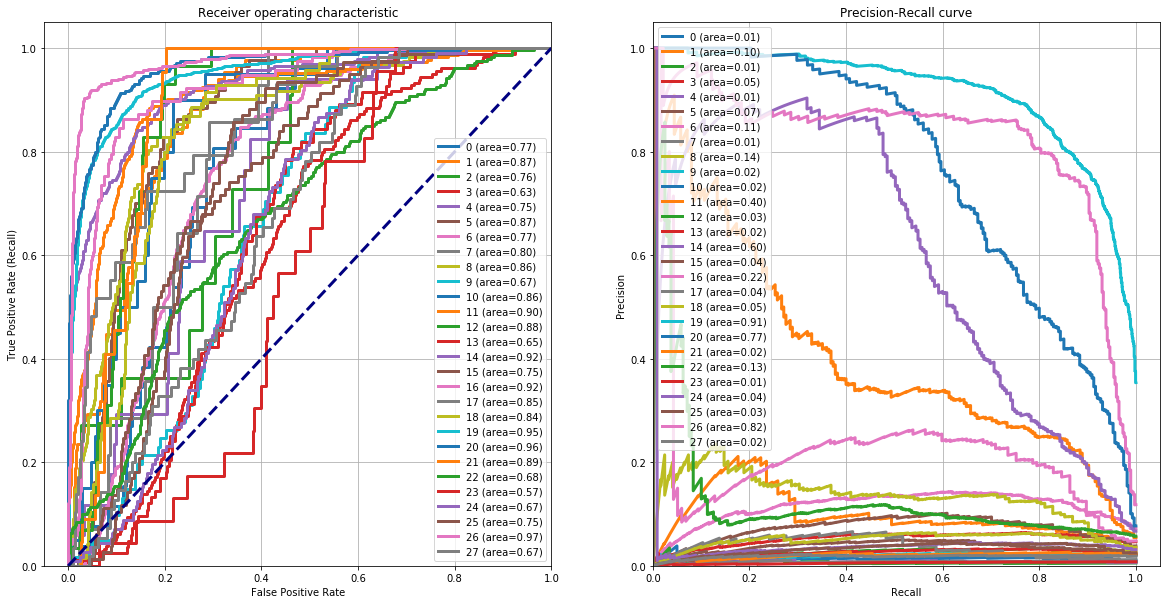

In [33]:
nn_Tfidf = MLPClassifier(solver="adam", hidden_layer_sizes=(50), alpha=3, activation="relu", max_iter=1000)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, False)

##### Conclusion sur le Neural Network Classifier

Le meilleur score pour ce modèle est obtenu avec les hyperparamètres suivants : `solver="lbfgs"`, `hidden_layer_sizes=(50)`, `alpha=1`, `activation="relu"` et `max_iter=5000`.

### Conlusion

A la suite de toutes ses expérimentations, les algorithmes de la famille **Naives Bayes** donnent des résultats plutôt encourageants : la précision maximale de *0.72* est atteinte pour l'un d'entre eux. On note aussi que la convergence est très rapide pour ce type d'algorithme et ce facteur est à prendre à compte pour notre modèle final.

Pour l'algorithme **RandomTree**, les scores obtenus sont un peu plus faibles, ce modèle ne sera donc pas retenu.

Le **KNN** propose lui aussi un manque de précision pour notre application.

Pour finir, le **Neural Network** est le modèle avec le meilleur score. Le précision pour le test atteint les *0.75* pour une liste d'hyperparamètres. Il s'agit du modèle le plus prometteur, car il est possible de faire encore évoluer ces paramètres.

### Tentative pipeline NN Algorithm

Cette dernière partie représente juste la tentative de pipeline pour le NN classifier.   

Lancé sur AWS, le système a réalisé un `kill -9` après environ 5 heures de calculs...

In [56]:
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'hidden_layer_sizes': [(50,)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs'],
    'alpha': [1, 0.1],
    'learning_rate': ['constant','adaptive'],
}

In [57]:
mlp = MLPClassifier(max_iter=1000)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(kNeighbors_count_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

exception calling callback for <Future at 0x7f91ad291320 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/ec2-us

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}